# 19장. 세상에 없는 얼굴 GAN, 오토인코더
<br>
* 생성적 적대 신경망(Generative Adversaial Networks) 줄여서 **GAN** 알고리즘
* GAN은 딥러닝의 원리를 활용해 가상 이미지를 생성하는 알고리즘
* 예를들어, 

##### 참고자료
* https://arxiv.org/pdf/1511.06434.pdf
* https://phillipi.github.io/pix2pix/
* https://medium.com/@juliendespois/latent-space-visualization-deep-learning-bits-2-bd09a46920df
* https://arxiv.org/pdf/1511.06434.pdf
* https://www.thispersondoesnotexist.com/
* https://www.youtube.com/watch?v=dCKbRCUyop8


* 생성자에서는 최적화(optimizer)과정이 필요하지x. 판별하는 과정이 없기 때문. 계속해서 가짜를 만들 뿐

### 1. 가짜 제조 공장, 생성자
* 생성자(generator)는 가상의 이미지를 만들내는 공장

### 2. 진위를 가려내는 장치, 판별자
* discriminator.trainable = False           # 판별자를 만들 때는 가중치를 저장하는 학습 기능을 "반드시" 꺼 주어야함 

### 3. 적대적 신경망 실행하기
* 생성자와 판별자를 연결시킨다는 것은 생성자에서 나온 출력을 판별자에 넣어서 진위 여부를 판별하게 만든다는 의미. 
* 생성자를 G(), 판별자를 D(), 실제 데이터를 x, 입력값을 input이라고 하면 아래와 같음.

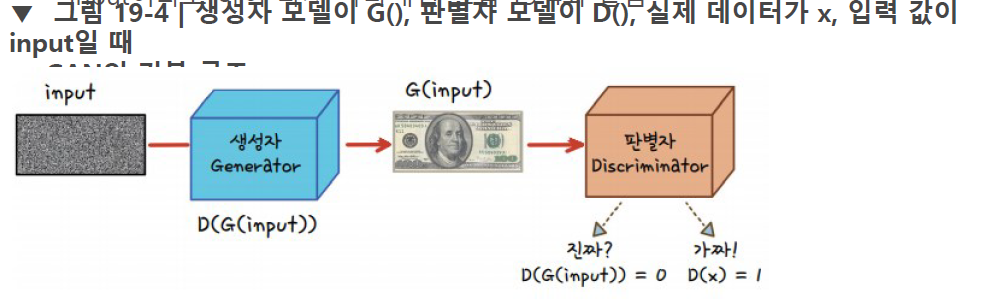

##### 실습 GAN 모델 만들기

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_5 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________
1/1 [==============================] - 0s 130ms/step
epoch:0  d_loss:0.6963  g_loss:0.6367
1/1 [==============================] - 0s 42ms/step
epoch:1  d_loss:0.3940  g_loss:0.2327
1/1 [==============================] - 0s 41ms/step
epoch:2  d_loss:0.3817  g_loss:0.0196
1/1 [=====

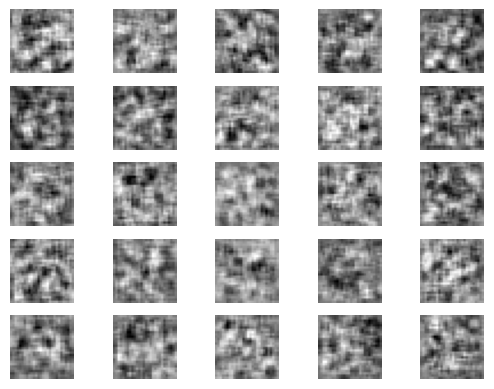

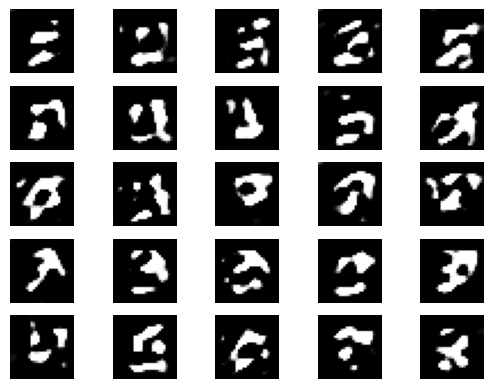

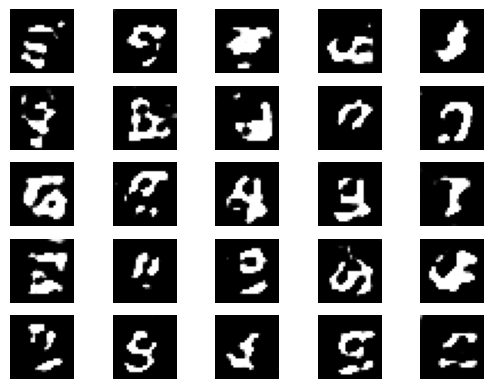

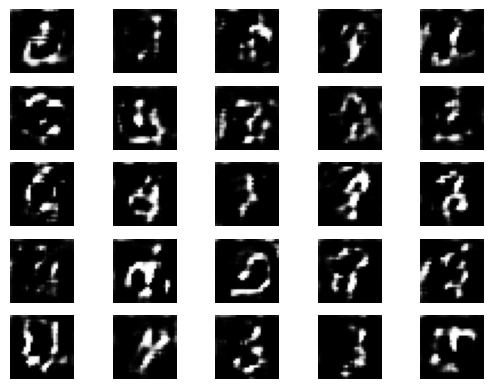

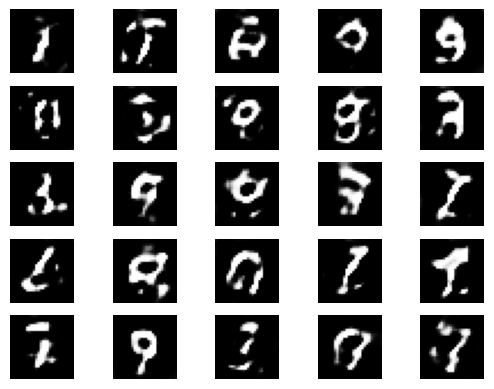

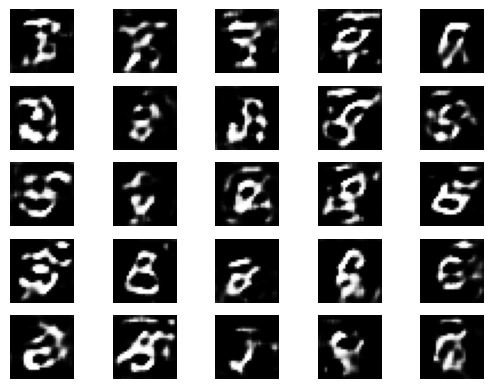

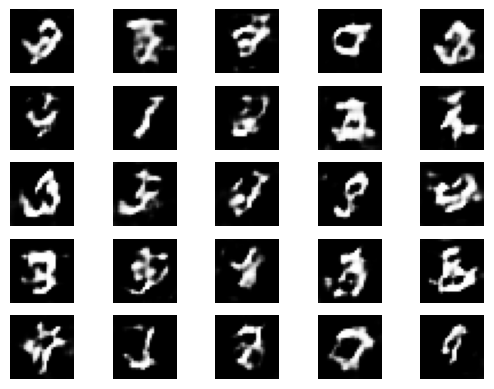

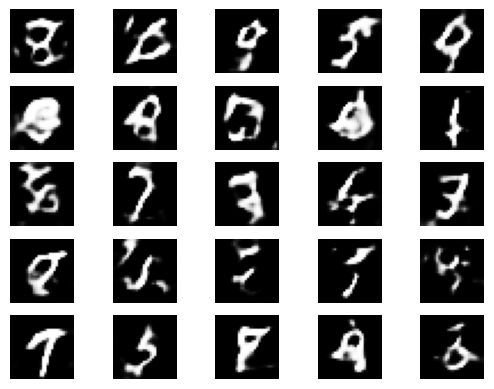

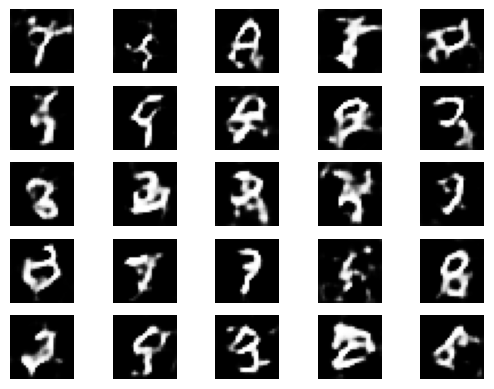

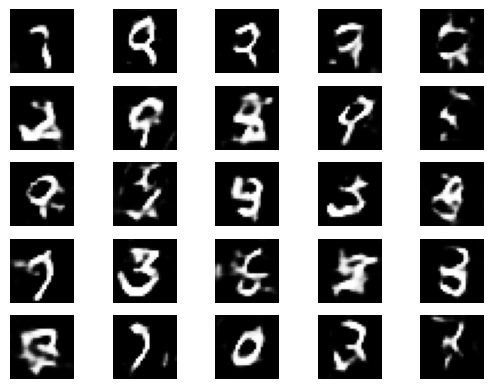

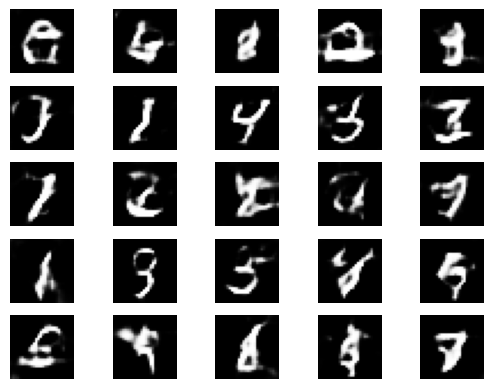

In [3]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import matplotlib.pyplot as plt

# 예제 파일에서 data 폴더 아래에 이미지가 저장될 gan_images 폴더가 함께 제공됩니다.
# 만약 이미지가 저장될 폴더가 없다면 아래 코드의 주석을 해제해 gan_images 폴더를 만듭니다.
# import os
# if not os.path.exists("./data/gan_images"):
#    os.makedirs("./data/gan_images")

# 생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

# 판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

# 생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

# 신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터를 불러옵니다.

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트 과정은 필요 없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀 값은 0에서 255 사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1 사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  # X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          # 가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          # 판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이 부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스 코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("../data/gan_images/gan_mnist_%d.png" % i)

gan_train(2001, 32, 200)  # 2000번 반복되고, 배치 사이즈는 32,  200번마다 결과가 저장되게 하였습니다.


### 4. 이미지의 특징을 추출하는 오토인코더
* 오토인코더: 딥러닝을 이용해 가상의 이미지를 만드는 또 하나의 유명한 알고리즘
* 오토인코더는 GAN과  비슷한 결과를 만들지만 다른 성질을 가지고 있다. 
* GAN은 세상에 존재하지 않는 완전한 가상의 것을 만들어내는 반면에, <br>
오토인코더는 입력 데이터의 특징을 효율적으로 담아낸 이미지를 만들어 낸다. 
* 예시
    * GAN으로 사람의 얼굴을 만들면 진짜같아 보여도 실제로는 존재하지 않는 완전한 가상 이미지가 만들어짐
    * 오토인코더로 사람의 얼굴을 만들 경우 초점이 흐릿하고 윤곽이 불명확하지만 사람의 특징을 유추할 수 있는 것들이 모여 이미지가 만들어짐
    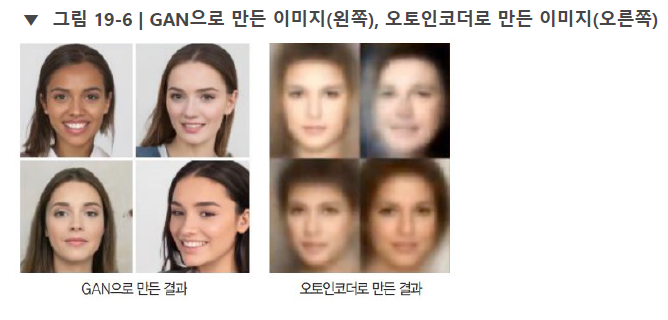

* 오토인코더 활용분야
    * 영상의학 분야 등 아직 데이터 수가 충분하지 않은 분야에서 사용될 수 있다. 
    * 학습 데이터는 현실 세계의 정보를 담고 있어야하므로, 세상에 존재하지 않는 가상의 것을 넣으면 예상치 못한 결과를 가져올 수 있다. 
    * 데이터의 특징을 잘 담아내는 오토인코더라면 다르다.
    * 부족한 학습 데이터 수를 효과적으로 늘려주는 효과를 기대할 수 있다. 
* 오토인코더 특징
    * 오토인코더의 학습은 GAN 학습보다 훨씬 쉽다. 
    * 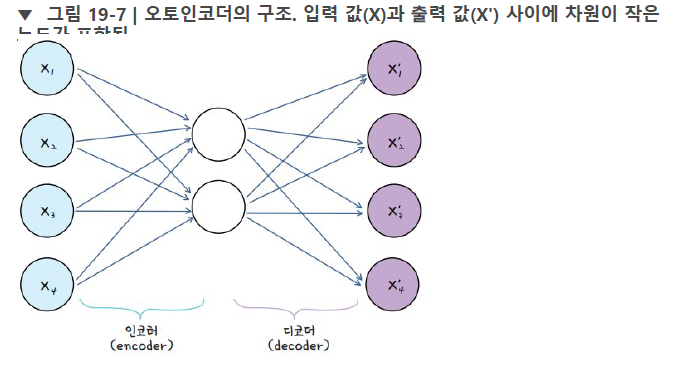
    * 그림 19-7 을 보면 입력한 이미지와 똑같은 크기로 출력층을 만들었다. 
    * 입력층보다 적은 수의 노드를 가진 은닉층을 중간에 넣어서 차원을 줄여준다. 
    * 이 때 소실된 데이터를 복원하기 위해 학습을 시작하고, 이 과정을 통해 입력 데이터의 특징을 효율적으로 응축한 새로운 출력이 나오는 원리
    

##### 실습: 오토인코더 실습하기
* 입력갯수와 출력갯수가 같아야한다. 

In [4]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
import matplotlib.pyplot as plt
import numpy as np

# MNIST 데이터셋을 불러옵니다.

(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

# 생성자 모델을 만듭니다.
autoencoder = Sequential()

# 인코딩 부분입니다.
autoencoder.add(Conv2D(16, kernel_size=3, padding='same', input_shape=(28,28,1), activation='relu'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, activation='relu', padding='same'))
autoencoder.add(MaxPooling2D(pool_size=2, padding='same'))
autoencoder.add(Conv2D(8, kernel_size=3, strides=2, padding='same', activation='relu'))

# 디코딩 부분이 이어집니다. 
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(8, kernel_size=3, padding='same', activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(16, kernel_size=3, activation='relu'))
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))

# 전체 구조를 확인해 봅니다.
autoencoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 8)           584       
                                                                 
 conv2d_15 (Conv2D)          (None, 4, 4, 8)          

In [5]:
# 컴파일 및 학습을 하는 부분입니다.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_test, X_test))

# 학습된 결과를 출력하는 부분입니다.
random_test = np.random.randint(X_test.shape[0], size=5)  # 테스트할 이미지를 랜덤하게 불러옵니다.
ae_imgs = autoencoder.predict(X_test)                     # 앞서 만든 오토인코더 모델에 집어 넣습니다.

plt.figure(figsize=(7, 2))                         # 출력될 이미지의 크기를 정합니다.

for i, image_idx in enumerate(random_test):       # 랜덤하게 뽑은 이미지를 차례로 나열합니다.
   ax = plt.subplot(2, 7, i + 1) 
   plt.imshow(X_test[image_idx].reshape(28, 28))   # 테스트할 이미지를 먼저 그대로 보여줍니다.
   ax.axis('off')
   ax = plt.subplot(2, 7, 7 + i +1)
   plt.imshow(ae_imgs[image_idx].reshape(28, 28)) # 오토인코딩 결과를 다음열에 출력합니다.
   ax.axis('off')
plt.show()

Epoch 1/50
469/469 [==============================] - 53s 109ms/step - loss: 0.2109 - val_loss: 0.1399
Epoch 2/50
469/469 [==============================] - 53s 113ms/step - loss: 0.1280 - val_loss: 0.1176
Epoch 3/50
469/469 [==============================] - 60s 127ms/step - loss: 0.1143 - val_loss: 0.1089
Epoch 4/50
469/469 [==============================] - 52s 111ms/step - loss: 0.1074 - val_loss: 0.1037
Epoch 5/50
469/469 [==============================] - 50s 107ms/step - loss: 0.1031 - val_loss: 0.1007
Epoch 6/50
469/469 [==============================] - 46s 98ms/step - loss: 0.1001 - val_loss: 0.0978
Epoch 7/50
469/469 [==============================] - 48s 102ms/step - loss: 0.0979 - val_loss: 0.0961
Epoch 8/50
469/469 [==============================] - 48s 103ms/step - loss: 0.0962 - val_loss: 0.0941
Epoch 9/50
469/469 [==============================] - 46s 99ms/step - loss: 0.0946 - val_loss: 0.0929
Epoch 10/50
469/469 [==============================] - 45s 96ms/step - loss

KeyboardInterrupt: 